# 第15章 自然语言处理：应用

## 15.1 情感分析及数据集

### 练习15.1.1

我们可以修改本节中的哪些超参数来加速训练情感分析模型？

**解答：**

&emsp;&emsp;  [本节](https://zh-v2.d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-and-dataset.html#id7)中提到如下内容。因此，我们可以修改本节中 **序列长度** 来加速训练情感分析模型，即减小每个评论的长度，从而减小每一个批量的大小，加速训练情感分析模型。

>正如我们所料，评论的长度各不相同。为了每次处理一小批量这样的评论，我们通过截断和填充将每个评论的长度设置为500。

### 练习15.1.2

请实现一个函数来将[Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)的数据集加载到数据迭代器中进行情感分析。

**解答：**

&emsp;&emsp; 以下是一个示例函数，用于加载Amazon reviews数据集并将其转换为可用于情感分类的数据迭代器。在这个函数中，假设数据集以csv格式存储，其中每行包含一个评论文本及其对应的情感标签，这些元素由制表符分隔。在使用这个实例函数时，只需将 `load_amazon_reviews` 函数的参数设置为数据集文件路径和所需的批量大小即可。

In [1]:
# 导入所需的库
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# 创建一个名为AmazonReviewDataset的数据集类，用于加载亚马逊评论数据集
class AmazonReviewDataset(Dataset):
    def __init__(self, file_path):  # 初始化方法，接收文件路径作为输入
        self.data = pd.read_csv(file_path, sep='\t')  # 从文件中读取数据并存储在self.data中

    def __len__(self):  # 返回数据集的大小
        return len(self.data)

    def __getitem__(self, idx):  # 获取指定索引处的数据样本
        text = self.data.iloc[idx]['text']  # 获取文本数据
        label = self.data.iloc[idx]['label']  # 获取标签数据
        return text, label  # 返回文本和标签

# 创建一个函数load_amazon_reviews，用于加载亚马逊评论数据集
def load_amazon_reviews(file_path, batch_size):
    dataset = AmazonReviewDataset(file_path)  # 创建AmazonReviewDataset实例
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # 创建数据加载器
    return dataloader  # 返回数据加载器实例

## 15.2 情感分析：使用循环神经网络

### 练习15.2.1

增加迭代轮数可以提高训练和测试的准确性吗？调优其他超参数怎么样？

**解答：**

&emsp;&emsp; 增加迭代轮数可以提高训练的准确性，但是不一定能够提高测试的准确性。也可以调节批大小和学习率来观察训练和测试的准确率。

In [ ]:
# 导入相关依赖，设置批大小
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [16]:
# 使用循环神经网络表示单个文本
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()

**学习率为0.01，迭代次数为5**

loss 0.294, train acc 0.876, test acc 0.854
636.0 examples/sec on [device(type='cuda', index=0)]


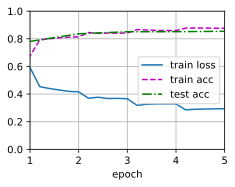

In [26]:
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

# 为词表中的单词加载预训练的100维（需要与embed_size一致）的GloVe嵌入。
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
# embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.01, 5  # 学习率为0.01，迭代次数为5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

**学习率为0.01，迭代次数为10**

loss 0.180, train acc 0.928, test acc 0.845
635.0 examples/sec on [device(type='cuda', index=0)]


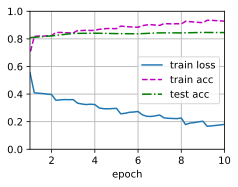

In [24]:
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

# 为词表中的单词加载预训练的100维（需要与embed_size一致）的GloVe嵌入。
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
# embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

lr, num_epochs = 0.01, 10  # 学习率为0.01，迭代次数为10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

**学习率为0.01，迭代次数为20**

loss 0.112, train acc 0.958, test acc 0.848
639.5 examples/sec on [device(type='cuda', index=0)]


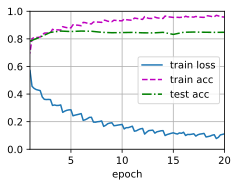

In [23]:
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

# 为词表中的单词加载预训练的100维（需要与embed_size一致）的GloVe嵌入。
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
# embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

lr, num_epochs = 0.01, 20  # 学习率为0.01，迭代次数为20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

**学习率为0.003，迭代次数为6**

loss 0.285, train acc 0.881, test acc 0.861
633.3 examples/sec on [device(type='cuda', index=0)]


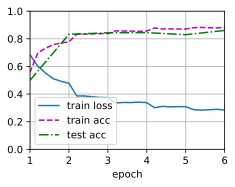

In [31]:
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

# 为词表中的单词加载预训练的100维（需要与embed_size一致）的GloVe嵌入。
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
# embeds.shape
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.003, 6  # 学习率为0.003，迭代次数为6
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

&emsp;&emsp; 总结：

| learning rate | epoch | result |
|:--:|:--:|:--:|
|0.01  | 5  | loss 0.294, train acc 0.876, test acc 0.854 |
|0.01  | 10 | loss 0.180, train acc 0.928, test acc 0.845 |
|0.01  | 20 | loss 0.112, train acc 0.958, test acc 0.848 |
|0.003 | 6  | loss 0.285, train acc 0.881, test acc 0.861 |


&emsp;&emsp; 因此增加迭代轮数可以提高训练的准确性，但是会出现过拟合的情况，降低了在测试集上面的准确性。减小学习率可以提高测试集的精度。

### 练习15.2.2

使用较大的预训练词向量，例如300维的GloVe嵌入。它是否提高了分类精度？

**解答：**

&emsp;&emsp;可以通过使用更大的预训练词向量，提高分类精度。接下来用代码验证上述结论：

&emsp;&emsp;官方使用的是100维的Embedding
1. embed_size, num_hiddens, num_layers = 100, 100, 2  
2. glove_embedding = d2l.TokenEmbedding('glove.6b.100d')  

&emsp;&emsp;训练结果   
1. loss = 0.304，train acc = 0.876，test acc = 0.853

&emsp;&emsp;根据书本14.7.1加载预训练词向量  
1. embed_size, num_hiddens, num_layers = 300, 100, 2  # 注意需要对应embed_size     
2. glove_embedding = d2l.TokenEmbedding('glove.42b.300d')  # 42 Billions参数，300维     

&emsp;&emsp;训练结果  
1. loss = 0.214，train acc = 0.917，test acc = 0.863

In [ ]:
# 详细代码如下
import os
import torch
from torch import nn
from d2l import torch as d2l  # 需要预先下载好d2l包


# 确保已经正确安装了troch,cuda
import torch
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")


batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)  # 加载相关数据

In [2]:
# 相关GloVe模型地址
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')


# 加载预训练的词向量，这部分与官方保持一致。
#@save
class TokenEmbedding:
    """GloVe嵌入"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r',encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)


# 定义循环神经网络，这部分与官方保持一致。
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])


embed_size, num_hiddens, num_layers = 100, 100, 2
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights)
devices = d2l.try_all_gpus()

官方示例里，词表中的单词加载预训练的100维（需要与embed_size一致）的GloVe嵌入。

In [3]:
glove_embedding_100 = TokenEmbedding('glove.6b.100d')

loss 0.415, train acc 0.816, test acc 0.820
2004.1 examples/sec on [device(type='cuda', index=0)]


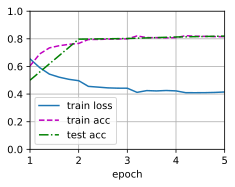

In [4]:
embeds = glove_embedding_100[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # 防止部分环境内存报错

# 训练和评估模型
lr, num_epochs = 0.01, 5
net.apply(init_weights)  # 若需多次运行这个cell，需要添加该句语句进行权重刷新
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

修改后，我们为词表中的单词加载预训练的300维（需要与embed_size一致）的GloVe嵌入。

In [5]:
embed_size, num_hiddens, num_layers = 300, 100, 2
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights)
devices = d2l.try_all_gpus()

In [6]:
glove_embedding_300 = TokenEmbedding('glove.42b.300d')

loss 0.212, train acc 0.917, test acc 0.867
1970.5 examples/sec on [device(type='cuda', index=0)]


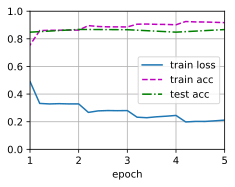

In [7]:
embeds = glove_embedding_300[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # 防止部分环境内存报错

# 训练和评估模型
lr, num_epochs = 0.01, 5
net.apply(init_weights)  # 若需多次运行这个cell，需要添加该句语句进行权重刷新
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

&emsp;&emsp;综上可知，使用较大的预训练词向量，提高了情感分类精度
1. 使用100维的Embedding，loss = 0.304，train acc = 0.876，test acc = 0.853
2. 使用300维的Embedding，loss = 0.214，train acc = 0.917，test acc = 0.863

### 练习15.2.3

&emsp;&emsp;是否可以通过spaCy词元化来提高分类精度？需要安装Spacy（`pip install spacy`）和英语语言包（`python -m spacy download en`）。在代码中，首先导入Spacy（`import spacy`）。然后，加载Spacy英语软件包（`spacy_en = spacy.load('en')`）。最后，定义函数`def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]`并替换原来的`tokenizer`函数。请注意GloVe和spaCy中短语标记的不同形式。例如，短语标记“new york”在GloVe中的形式是“new-york”，而在spaCy词元化之后的形式是“new york”。

**解答：**

&emsp;&emsp;
https://spacy.io/

&emsp;&emsp;可以通过spaCy词元化来提高分类精度。首先介绍spaCy：
> 来源地址：https://spacy.io/
> &emsp;&emsp;Get things done: spaCy is designed to help you do real work — to build real products, or gather real insights.The library respects your time, and tries to avoid wasting it. It's easy to install, and its API is simple andproductive.
> &emsp;&emsp;Blazing fast: spaCy excels at large-scale information extraction tasks. It's written from the ground up in carefully memory-managed Cython. If your application needs to process entire web dumps, spaCy is the library you want to be using.
> &emsp;&emsp;Awesome ecosystem: Since its release in 2015, spaCy has become an industry standard with a huge ecosystem.Choose from a variety of plugins, integrate with your machine learning stack and build custom components and workflows.

&emsp;&emsp;根据官网描述，spaCy 是一个免费的开源库，用于 Python 中的高级自然语言处理包括但不限于词性标注、dependency parsing、NER和相似度计算。它可帮助构建处理和理解大量文本的应用程序可用于多种方向，例如信息提取、自然语言理解或为深度学习提供文本预处理。我们使用spaCy库实现标记化包括将文本分割成单词、标点符号等，这是通过应用特定于每种语言的规则来完成的。

&emsp;&emsp;接下来用代码验证：

In [11]:
# d2l自带tokenize函数
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.

    Defined in :numref:`sec_text_preprocessing`"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

&emsp;&emsp;根据官方给的提示，我们对原函数进行小幅度修改。注意题目的意思是让我们修改tokenize这个函数（见github中的[torch.py](https://github.com/d2l-ai/d2l-zh/blob/master/d2l/torch.py)文件）而tokenize函数在load_data_imdb函数中进行调用，因此我们还需要对应修改这个函数。最终使用修改后的load_data_imdb函数读入数据。

In [12]:
def tokenize1(text): 
    return [tok.text for tok in spacy_en.tokenizer("".join(text))]  # 在官方提供示例基础上，稍作修改


def tokenize2(lines, token='word'):
    if token == 'word':
        return [tokenize1(line) for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

&emsp;&emsp;以下是完整可运行代码

In [13]:
# 完整可运行代码
import os
import torch
from torch import nn
from d2l import torch as d2l


# 编写tokenize2,使用spacy进行分词

import spacy  # 按照题目提示先安装好
spacy_en = spacy.load("en_core_web_sm")


def tokenize1(text): 
    return [tok.text for tok in spacy_en.tokenizer("".join(text))]  # 在官方提供示例基础上，稍作修改


def tokenize2(lines, token='word'):
    if token == 'word':
        return [tokenize1(line) for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [14]:
# 查看两种token方式的区别
doc = ["This new-york is a sentence.","df","df df"]
train_tokens = d2l.tokenize(doc, token='word')
print(train_tokens)
train_tokens = tokenize2(doc, token='word')  # 自己编写的tokenize2函数
print(train_tokens)

[['This', 'new-york', 'is', 'a', 'sentence.'], ['df'], ['df', 'df']]
[['This', 'new', '-', 'york', 'is', 'a', 'sentence', '.'], ['df'], ['df', 'df']]


In [15]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset.

    Defined in :numref:`sec_sentiment`"""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = d2l.read_imdb(data_dir, True)
    test_data = d2l.read_imdb(data_dir, False)
    train_tokens = tokenize2(train_data[0], token='word')
    test_tokens = tokenize2(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [16]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)  # 使用修改后的 load_data_imdb 函数，加载相关数据

In [17]:
# 相关GloVe模型地址
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')


# 加载预训练的词向量，这部分与官方保持一致。
#@save
class TokenEmbedding:
    """GloVe嵌入"""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r',encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)


# 定义循环神经网络，这部分与官方保持一致。
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])


embed_size, num_hiddens, num_layers = 100, 100, 2
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.apply(init_weights)
devices = d2l.try_all_gpus()

In [18]:
glove_embedding_100 = TokenEmbedding('glove.6b.100d')

loss 0.254, train acc 0.897, test acc 0.868
2037.0 examples/sec on [device(type='cuda', index=0)]


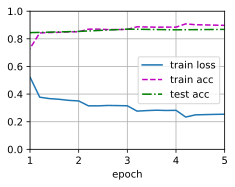

In [19]:
embeds = glove_embedding_100[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  # 防止部分环境内存报错

# 训练和评估模型
lr, num_epochs = 0.01, 5
net.apply(init_weights)  # 若需多次运行这个cell，需要添加该句语句进行权重刷新
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

&emsp;&emsp;综上可知，使用spaCy词元化，提高了情感分类精度
1. 使用默认的tokenize函数，loss = 0.304，train acc = 0.876，test acc = 0.853
2. 使用修改后的tokenize函数，loss = 0.270，train acc = 0.890，test acc = 0.867

## 15.3 情感分析：使用卷积神经网络

### 练习15.3.1

调整超参数，并比较15.2节中用于情感分析的架构和本节中用于情感分析的架构，例如在分类精度和计算效率方面。

**解答：**

- 在分类精度方面，对于相同的epoch，本节使用的卷积神经网络测试精度好于15.2节中所用的循环神经网络；
- 在计算效率方面，对于相同的epoch，本节使用的卷积神经网络的训练速度快于15.2节中用的循环神经网络。

| 架构 | learning rate (default) | epoch | result |
|:--:|:--:|:--:|:--:|
| RNN |0.01  | 5  | loss 0.294, train acc 0.876, test acc 0.854 |
| CNN |0.001 | 5  | loss 0.068, train acc 0.978, test acc 0.868 |
| RNN |0.01  | 10 | loss 0.180, train acc 0.928, test acc 0.845 |
| CNN |0.001 | 10 | loss 0.008, train acc 0.998, test acc 0.863 |
| RNN |0.01  | 20 | loss 0.112, train acc 0.958, test acc 0.848 |
| CNN |0.001 | 20 | loss 0.006, train acc 0.998, test acc 0.854 |

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [7]:
# 定义模型，下面的类中实现textCNN模型。
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

loss 0.068, train acc 0.978, test acc 0.868
2366.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


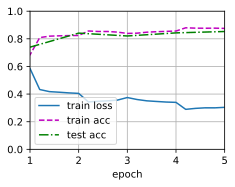

In [8]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.008, train acc 0.998, test acc 0.863
2831.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


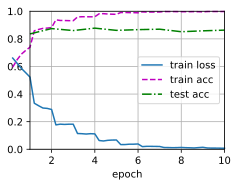

In [9]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.006, train acc 0.998, test acc 0.854
2839.8 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


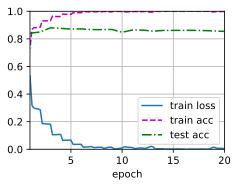

In [10]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.001, 20
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 练习15.3.2

请试着用15.2节练习中介绍的方法进一步提高模型的分类精度。

**解答：**

&emsp;&emsp;根据15.2练习结论，使用更大的预训练词向量、使用`spaCy`词元化，均可提高情感分类精度。以下是使用textCNN模型得到结论：
1. 根据下表1行，使用与15.2.2相同的数据集及超参数，实验的`test acc`、`test acc`两个字段对比得出：使用卷积神经网络模型训练存在过拟合现象，训练集准确率非常高，测试集上的表现比较差。
2. 根据下表1、4，3、5行对比得出：降低学习率对模型进行训练，能够略微提升`test acc`精度。
3. 根据下表1、2行对比得出：增加预训练模型的`Embedding`层数，增加`test acc`精度不明显（对层数不敏感）。
4. 根据下表1、2行对比得出：增加预训练模型的`Embedding`层数，降低了计算效率（见下方图像中 `XXX examples /sec on cuda`）。
5. 根据下表1、6，2、7行对比得出：使用`spaCy`词元化，略微提升`test acc`精度。

&emsp;&emsp;综上所述，使用textCNN模型做该情感分析时，使用更大的预训练词向量并没有提高分类准确率但降低了计算效率；使用`spaCy`词元化略微提升了分类准确率。

 row| tokenize | GloVe dimension | learning rate | epoch |  result |
 :-----: |---------:| :----: | :----: | :----: | :----: |
 1|  default | 100 | 0.01 | 5 | loss 0.031, train acc 0.989, test acc 0.857 |
 2| default |      300 | 0.01 | 5 | loss 0.046, train acc 0.984, test acc 0.857 |
 3| default |      100 | 0.01 | 10 | loss 0.022, train acc 0.993, test acc 0.850 |
 4| default |      100 | 0.001 | 5 | loss 0.075, train acc 0.976, test acc 0.870 |
 5| default |      100 | 0.001 | 10 | loss 0.008, train acc 0.998, test acc 0.866 |
 6| spaCy |      100 | 0.01 | 5 | loss 0.054, train acc 0.982, test acc 0.854 |
 7| spaCy |      100 | 0.001 | 5 | loss 0.113, train acc 0.961, test acc 0.877 |

<img src="../.././images/ch15-3-2-1-result.png?raw=true" width="336" height= "500">
<img src="../.././images/ch15-3-2-2-result.png?raw=true" width="336" height= "500">
<img src="../.././images/ch15-3-2-3-result.png?raw=true" width="336" height= "500">
<img src="../.././images/ch15-3-2-4-result.png?raw=true" width="336" height= "500">
<img src="../.././images/ch15-3-2-5-result.png?raw=true" width="336" height= "500">
<img src="../.././images/ch15-3-2-6-result.png?raw=true" width="336" height= "500">
<img src="../.././images/ch15-3-2-7-result.png?raw=true" width="336" height= "500">

### 练习15.3.3        

在输入表示中添加位置编码。它是否提高了分类的精度？

**解答：**

&emsp; &emsp; 在输入表示中添加位置编码，可以提高分类的精度，同时也降低了模型过拟合的程度。

-  关于位置编码的添加方式可参考 [transformer-note](https://github.com/WGS-note/transformer-note/blob/81a750f938ceb3c8d1ecb18ae6cf1aa0eff34124/transformer.py#L229) 。

In [14]:
import torch
from torch import nn
from d2l import torch as d2l
import math

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

- 定义类实现位置编码，参考[10.6自注意力与位置编码](https://zh.d2l.ai/chapter_attention-mechanisms/self-attention-and-positional-encoding.html)，之后在textCNN模型中添加位置编码到词嵌入向量。

loss 0.224, train acc 0.916, test acc 0.873
2829.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


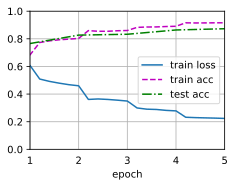

In [ ]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.0003, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.028, train acc 0.991, test acc 0.863
2838.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


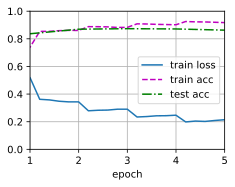

In [12]:
# 创建一个textCNN实例
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

# 训练和评估模型
lr, num_epochs = 0.003, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 15.4 自然语言推断与数据集

### 练习15.4.1

机器翻译长期以来一直是基于翻译输出和翻译真实值之间的表面$n$元语法匹配来进行评估的。可以设计一种用自然语言推断来评价机器翻译结果的方法吗？

**解答：**

&emsp;&emsp; 可以。随着自然语言处理技术的发展，自然语言推断已经成为了一种有效的评价机器翻译结果的方法。自然语言推断可以通过比较翻译输出和翻译真实值之间的逻辑关系来评估翻译质量。例如，可以使用逻辑推理技术来检测翻译输出是否与翻译真实值一致，或者是否存在逻辑矛盾或歧义。此外，还可以使用语义推理技术来比较翻译输出和翻译真实值之间的语义相似性。因此，自然语言推断可以为机器翻译的评估提供更加准确和全面的方法。

### 练习15.4.2    

我们如何更改超参数以减小词表大小？

**解答：**

&emsp;&emsp; 1. 减小词向量维度：词向量的维度越高，词表大小也越大。通过减小词向量的维度，可以减小词表大小。

&emsp;&emsp; 2. 减小最小词频：在构建词表时，可以设置一个最小词频阈值，只有出现次数大于该阈值的词才会被加入词表。通过减小最小词频阈值，可以减小词表大小。

&emsp;&emsp; 3. 使用更高级的词向量模型：一些高级的词向量模型，如BERT、GPT等，可以通过预训练的方式得到更加优秀的词向量表示，从而减小词表大小。

&emsp;&emsp; 4. 使用更加精细的分词工具：一些分词工具，如jieba、ltp等，可以通过设置不同的分词模式，得到更加精细的分词结果，从而减小词表大小。

&emsp;&emsp; 5. 去除停用词：停用词是指在文本中出现频率较高，但对文本语义没有贡献的词语，如“的”、“是”、“在”等。通过去除停用词，可以减小词表大小。

## 15.5 自然语言推断：使用注意力

### 练习15.5.1

使用其他超参数组合训练模型，能在测试集上获得更高的准确度吗？

**解答：**

&emsp; &emsp; 通过调节超参数组合，将所得的结果整理如下（注意每次训练的结果都有微小差别）：

| batch_size | num_steps | learning rate | num_epochs | result |
|:--:|:--:|:--:|:--:|:--:|
| 256 | 50 | 0.001  | 4 | loss 0.495, train acc 0.806, test acc 0.826 |
| 256 | 50 | 0.0003 | 4 | loss 0.547, train acc 0.780, test acc 0.810 |
| 256 | 50 | 0.003  | 4 | loss 0.631, train acc 0.740, test acc 0.752 |
| 256 | 50 | 0.001  | 6 | loss 0.462, train acc 0.820, test acc 0.829 |
| 256 | 50 | 0.001  | 8 | **loss 0.441, train acc 0.830, test acc 0.834** |
| 128 | 50 | 0.001  | 8 | loss 0.448, train acc 0.827, test acc 0.828 |
| 512 | 50 | 0.001  | 8 | **loss 0.440, train acc 0.829, test acc 0.834** |

&emsp;&emsp; 从表格可以看出，超参数组合 `batch_size = 512 / batch_size =256`, `num_steps = 50`,  `learning rate = 0.001`,  `num_epochs = 8`，测试集精度最好，可达到83.4%。

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [4]:
# 注意
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # A/B的形状：（批量大小，序列A/B的词元数，embed_size）
        # f_A/f_B的形状：（批量大小，序列A/B的词元数，num_hiddens）
        f_A = self.f(A)
        f_B = self.f(B)
        # e的形状：（批量大小，序列A的词元数，序列B的词元数）
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # beta的形状：（批量大小，序列A的词元数，embed_size），
        # 意味着序列B被软对齐到序列A的每个词元(beta的第1个维度)
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # beta的形状：（批量大小，序列B的词元数，embed_size），
        # 意味着序列A被软对齐到序列B的每个词元(alpha的第1个维度)
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha
    
# 比较
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B
    
# 聚合
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # 对两组比较向量分别求和
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # 将两个求和结果的连结送到多层感知机中
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [5]:
# 定义可分解注意力模型
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # 有3种可能的输出：蕴涵、矛盾和中性
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

loss 0.495, train acc 0.806, test acc 0.826
14133.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


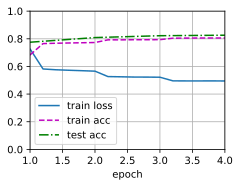

In [14]:
# 读取数据集
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

# 创建模型
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

# 训练和评估模型
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.441, train acc 0.830, test acc 0.834
14859.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


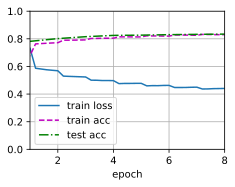

In [15]:
# 读取数据集
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

# 创建模型
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

# 训练和评估模型
lr, num_epochs = 0.001, 8
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.440, train acc 0.829, test acc 0.834
22247.6 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


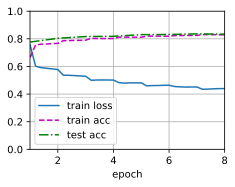

In [8]:
# 读取数据集
batch_size, num_steps = 512, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

# 创建模型
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

# 训练和评估模型
lr, num_epochs = 0.001, 8
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 练习15.5.2

自然语言推断的可分解注意模型的主要缺点是什么？

**解答：**

&emsp;&emsp;自然语言推断（Natural Language Inference，NLI）是一种探究自然语言文本之间逻辑关系的技术，可用于识别文本之间的关联性、推理结论等等。可分解注意模型（Decomposable Attention Model）是在NLI任务中广泛应用的模型之一，它使用了注意力机制和神经网络来实现文本比较和推断加工。它被认为是一个具有效果显著的模型，但是它也存在一些主要缺点，这些缺点包括以下几个方面：
1. 上下文无关性： 可分解注意模型在处理文本时不考虑上下文，这使得它无法识别一些依赖上下文才能确定语义的词汇和短语。可分解注意模型仅仅基于词汇和短语本身进行推断，因此无法获得更深层次的语意。
2. 描述限制性： 可分解注意模型的处理能力也受到其内部描述的限制。该模型所使用的神经网络仅能处理输入数据中的某些特定方面，如词汇、语法、句法等，但忽略了一些其他方面，比如书面语的后缀式表达、重音、语气等。这些方面对于文本推断任务来说至关重要，如果无法捕捉到这些特征，会导致模型推断的精度下降。同时，可分解注意力模型对每个子任务独立进行计算，这可能会导致信息丢失或整合不充分的情况。
3. 计算复杂度：对于大规模数据集，可分解注意模型的多个子任务，通常涉及对输入句子中的词或词组进行注意力机制处理。即使是并行处理，多次计算依然需要更多的计算资源和时间。
4. 训练困难： 可分解注意模型的训练需要大量的数据，并且需要精心设置模型参数和超参数，这将带来训练成本的增加和收敛速度的降低。此外，可分解注意模型的推理过程基于向量间的抽象表示，这意味着模型的收敛是受到维数灾难的影响的，因为在高维空间中，距离的计算和推理变得更加困难。

综上所述，尽管可分解注意模型是一个被广泛使用的NLI模型，并且它取得了一定的成果，但是其存在一些重要的缺点，这些缺点限制了模型能力的提高和应用领域的扩展。

### 练习15.5.3

假设我们想要获得任何一对句子的语义相似级别（例如，0～1之间的连续值）。我们应该如何收集和标注数据集？请尝试设计一个有注意力机制的模型。

**解答：**

&emsp;&emsp;要获得句子之间的语义相似度，需要收集一个包含句子对及其相似程度的标注数据集。下面是一些可能的方法来构建这样的数据集：
1. 众包标注：可以使用在线平台，如Amazon Mechanical Turk等，招募众包工人来对句子对之间的语义相似程度进行标注。在这个过程中，众包工人将对给定句子对的相似程度进行打分。最后基于多位标注者的平均或者多数表决来确定标注值。
2. 专家标注：在这种方法中，专家可以被邀请来对句子对之间的相似程度进行标注。这可以通过招募领域专家或者语义学家来实现。

&emsp;&emsp;在标注数据集收集完毕之后，就可以考虑构建一个具有注意力机制的模型来进行语义相似性计算。以下是一种可能的基于注意力机制的模型架构：
1. 句子编码器：对于每个输入句子，使用一个预训练的词嵌入模型（如Word2Vec或GloVe）来将其编码成一个向量表示。
2. 对齐层：将两个句子的向量表示输入到一个对齐层中，通过用注意力机制来计算句子之间词元级别的相似度，将两个句子的每个词元软对齐，将两组词元比较、并聚合求和两组比较向量得到的值作为预训练好的词向量，做下一步推理层的输入。
3. 推理层：将对齐后的向量表示作为输入，使用线性回归（Linear Regression）、支持向量回归（Support Vector Regression）等模型算法输出一个连续值，即句子对之间的语义相似度得分。
4. 使用正则化技（如增加L1、L2正则项）和一些常见的训练技巧（如批处理、学习率调整等），训练出具有良好泛化能力的语义相似度计算模型。

## 15.6 针对序列级和词元级应用微调BERT

### 练习15.6.1

让我们为新闻文章设计一个搜索引擎算法。当系统接收到查询（例如，“冠状病毒爆发期间的石油行业”）时，它应该返回与该查询最相关的新闻文章的排序列表。假设我们有一个巨大的新闻文章池和大量的查询。为了简化问题，假设为每个查询标记了最相关的文章。如何在算法设计中应用负采样（见14.2.1节）和BERT？

**解答：**

&emsp;&emsp; 在系统接收到查询后，可以将返回与该查询最相关的新闻文章作为正样本（1），然后从新闻文章池和大量的查询中随机选取一篇新闻与查询短语构成负样本（0），最后应用softmax分类器将此问题转化为二分类问题，即与查询语句最相关的输出1，其他的输出0。

&emsp;&emsp;可以使用BERT来建立一个预训练的语言模型，以便在查询中识别重要的关键字和短语，并生成文章的特征向量。给定一个查询，我们可以使用BERT将该查询转换为一个向量，然后通过计算该查询向量和每篇文章的向量之间的余弦相似度来衡量文章与查询的相关性。在实际应用中，我们可以将BERT模型的计算与负采样结合起来，以便在给定一个查询时快速找出最相关的文章。

### 练习15.6.2        

我们如何利用BERT来训练语言模型？

**解答：**

&emsp;&emsp;本书14.8节
> &emsp;&emsp;BERT（来自Transformer的双向编码器表示）结合了ELMo和GPT的优点，对上下文进行双向编码，并且对于大多数的自然语言处理任务只需要对架构进行最小更改。通过使用预训练的Transformer编码器，BERT能够基于其双向上下文表示任何词元。

BERT的输入表示、预训练和微调过程：
1. 输入表示：输入序列是词元嵌入、段嵌入和位置嵌入的和。
2. 预训练：BERT的预训练分为两个阶段：掩码语言建模和下一句预测。在掩码语言建模阶段，在输入句子中随机掩盖一个单词，并通过上下文来预测该单词，这样的学习使得模型能够对双向上下文编码来表示词。在下一句预测阶段，通过学习判断两个句子是否相邻，以此来进一步提升模型的上下文适应能力，模型显式地对文本对之间的逻辑关系进行建模。
2. 微调：使用大量有标注的数据对预训练模型进行微调，以适应特定的自然语言处理任务，比如情感分类、命名实体识别、问答系统等等。  

利用BERT训练语言模型：
1. 输入编码：将每个输入句子分别转化为其对应的词向量。使用BERT模型内置的词嵌入模型BERTEncoder来生成输入编码，包括词元嵌入、段嵌入、位置嵌入。
2. 模型架构：BERT模型主要由Transformer编码器模块组成，用于产生特定层的抽象表示。
3. 预训练阶段：在BERT的预训练阶段中，采用了自监督的方式进行学习，在大量无标注数据上进行训练。包括掩码语言建模和下一句预测阶段，通过预测上下文中的词来学习语言的语法、语义及上下文信息。
4. 微调：针对特定任务的特性，使用有标注数据对预训练模型进行有监督训练。可使用传统的反向传播优化算法进行微调训练，可调整预训练阶段的参数或增加新层来优化模型，提高模型精度。
5. 微调结束后，使用验证集评估模型性能，并根据评估结果选择最优模型进行测试、部署。
综上所述，BERT是一种基于Transformer的预训练语言模型，其预训练模型可以通过训练大规模无标注的语料库来获得，并可使用有标注数据进行微调，以适应特定的任务。  

### 练习15.6.3

我们能在机器翻译中利用BERT吗？

**解答：**

&emsp;&emsp;是的，可以在机器翻译中利用用BERT生成高质量目标语言翻译。在传统机器翻译中，通常采用由两个不同的神经网络组成的编码器-解码器（Encoder-Decoder）框架，在编码器中将输入语言中的单词序列映射到语义表示，并在解码器中将其转换为目标语言。
&emsp;&emsp;使用BERT进行机器翻译的主要思路是将源语言和目标语言的句子对作为输入，通过训练使BERT学习到语言之间的转换规则。使用预训练的BERT编码器代替传统的编码器神经网络。BERT编码器可以使用自然语言句子对来预测句子的上下文表示，这种方式可以减少机器翻译中常见的困难，例如歧义消解和多义性。因此，在机器翻译任务中使用BERT编码器可以提高模型的性能和翻译质量。
具体步骤为：
1. 预训练：使用大量的双语语料库对BERT进行预训练。这些语料库包含源语言和目标语言的句子对。通过在源语言和目标语言之间进行训练，捕获到句子中的语义信息，并学习到如何将源语言的句子转化为目标语言的句子，BERT主要学习语言之间的转换规则。
2. 微调：使用目标任务的特定数据对预训练的BERT进行微调。这些数据是源语言到目标语言的翻译数据，通过有监督训练，让BERT更好的适应翻译任务。
3. 翻译：BERT模型主要由两个部分组成：Encoder和Decoder。Encoder负责将源语言的句子转化为向量表示，Decoder则将Encoder的输出作为输入，生成目标语言的翻译。
4. BERT还可以与其他技术结合使用以提高翻译质量。例如，可以使用束搜索（Beam Search）算法来生成高质量的翻译候选，或者使用注意力机制（Attention Mechanism）来增强Decoder对Encoder输出的理解。
使用BERT进行机器翻译可以提高模型的性能，但在实践中，需要许多技巧来克服BERT的训练和调整的高额成本。例如，可以使用多任务学习和预训练技术来提高模型的效率和泛化能力。此外，还需要注意数据选择和处理，以便更好地适应机器翻译任务 。

## 15.7 自然语言推断：微调BERT

### 练习15.7.1

&emsp;&emsp;如果您的计算资源允许，请微调一个更大的预训练BERT模型，该模型与原始的BERT基础模型一样大。修改`load_pretrained_model`函数中的参数设置：将“bert.small”替换为“bert.base”，将`num_hiddens=256`、`ffn_num_hiddens=512`、`num_heads=4`和`num_layers=2`的值分别增加到768、3072、12和12。通过增加微调迭代轮数（可能还会调优其他超参数），你可以获得高于0.86的测试精度吗？

**解答：**

In [2]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
# 加载预训练的BERT
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [4]:
# # 实现了以下load_pretrained_model函数来加载预先训练好的BERT参数
# def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
#                           num_heads, num_layers, dropout, max_len, devices):
#     data_dir = d2l.download_extract(pretrained_model)
#     # 定义空词表以加载预定义词表
#     vocab = d2l.Vocab()
#     vocab.idx_to_token = json.load(open(os.path.join(data_dir,
#         'vocab.json')))
#     vocab.token_to_idx = {token: idx for idx, token in enumerate(
#         vocab.idx_to_token)}
#     bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
#                          ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
#                          num_heads=4, num_layers=2, dropout=0.2,
#                          max_len=max_len, key_size=256, query_size=256,
#                          value_size=256, hid_in_features=256,
#                          mlm_in_features=256, nsp_in_features=256)
#     # 加载预训练BERT参数
#     bert.load_state_dict(torch.load(os.path.join(data_dir,
#                                                  'pretrained.params')))
#     return bert, vocab

# devices = d2l.try_all_gpus()
# bert, vocab = load_pretrained_model(
#     'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
#     num_layers=2, dropout=0.1, max_len=512, devices=devices)

# devices = d2l.try_all_gpus()
# bert, vocab = load_pretrained_model(
#     'bert.base', num_hiddens=768, ffn_num_hiddens=3072, num_heads=12,
#     num_layers=12, dropout=0.1, max_len=512, devices=devices)

> 注：本节中《动手学深度学习》中英文版本关于 `load_pretrained_model` 函数的定义，参数的名称有细微不同。
> - [中文版](https://zh.d2l.ai/chapter_natural-language-processing-applications/natural-language-inference-bert.html)：`def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, num_layers, dropout, max_len, devices):`                        
> - [英文版](https://d2l.ai/chapter_natural-language-processing-applications/natural-language-inference-bert.html)：`def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len, devices):`
> - 中文版中的参数 `num_layers` 对应英文版中的参数 `num_blks` 。

In [5]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len,devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,'vocab.json')))
    vocab.token_to_idx = {token:idx for idx,token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab),num_hiddens=num_hiddens,norm_shape=[768],
                               ffn_num_input=768,ffn_num_hiddens=ffn_num_hiddens,
                               num_heads=num_heads,num_layers=num_layers,
                               dropout=dropout,max_len=max_len,
                               key_size=768,query_size=768,value_size=768,
                               hid_in_features=768,mlm_in_features=768,nsp_in_features=768)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,'pretrained.params')))
    return bert,vocab

devices = d2l.try_all_gpus()
bert,vocab = load_pretrained_model('bert.base',num_hiddens=768,ffn_num_hiddens=3072,
                                    num_heads=12,num_layers=12,dropout=0.1,max_len=512,devices=devices)

In [6]:
# 微调BERT的数据集
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

&emsp;&emsp; 这里可以根据显存的大小来设置 `batch_size` ，下面示例代码中 `batch_size = 64`。

In [7]:
# 如果出现显存不足错误，请减少“batch_size”。在原始的BERT模型中，max_len=512
batch_size, max_len, num_workers = 64, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples
read 9824 examples


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# 微调BERT
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(768, 3)  # 注意修改全连接层的输入维度，与num_hiddens一致

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

loss 0.310, train acc 0.889, test acc 0.853
86.4 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


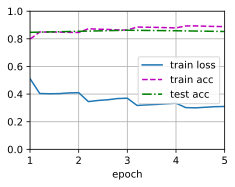

In [9]:
net = BERTClassifier(bert)
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

&emsp;&emsp; 本题测试精度为0.853，相比于书中0.785的测试精度提高了不少。本题的代码是在kaggle上面运行的，GPU资源：GUP T4 $\times$ 2 ，运行时间9h左右。如果要获得更高的测试精度，可以增加 `num_epochs` 的值，读者朋友可以自行尝试。

### 练习15.7.2

如何根据一对序列的长度比值截断它们？将此对截断方法与`SNLIBERTDataset`类中使用的方法进行比较。它们的利弊各是什么？

**解答：**

&emsp;&emsp;当两个序列的长度比例差别大的时候，我们需要根据一些准则对它们进行截断，以使它们的长度能够适应模型的输入要求。一些常见的截断方式包括：
1. 从两个序列中选取一定数量的token，仅保留这些token，将其余部分截断。
2. 基于最大长度将序列截断。这个截断方式比较直接，可以确保所有的序列都不超过一定的长度。
3. 在截断较长序列时，可以采用滑动截断的方式，将较长的序列分成多个重叠的部分，将其视为一系列类似序列进行处理和输入。

&emsp;&emsp;根据一对序列的长度比值进行截断的方法是为了解决两个序列长度不一致的问题。好处是可以根据实际情况动态地截断序列，从而更好地保留有用的信息。但是，这种方法需要计算两个序列的长度比值，并且需要设定一个合适的阈值来确定是否需要进行截断。此外，如果序列长度差异很大，这种方法可能会导致其中一个序列被过度截断。
&emsp;&emsp;对于SNLIBERTDataset等数据集类，通常采用基于最大长度的方法来截断序列。进行截断，即在确定最大长度后对序列进行截断。截断后，将被截断的序列填充后再输入到模型中。这种方法是为了确保所有序列都有一个最大长度，从而避免模型在训练时出现维度不匹配的问题。由于这个方法直接，容易实现，因此是常用的截断方式之一。但是，它可能会导致一些序列被过早地截断，从而丢失一些有用的信息。
&emsp;&emsp;综上所述，这两种截断方法各有利弊。基于最大长度的方法简单易行，但可能会过早地截断序列；而根据一对序列的长度比值进行截断的方法可以根据实际情况动态地截断序列，但需要设定合适的阈值，并且需要注意避免过度截断。在实际应用中，如何分割这个长序列并如何选择对应长度的子序列，需要考虑多种因素，例如输入模型的最大长度、固定的截断长度，以及序列本身的结构等。截断的主要优点是避免长序列对模型的消耗进行限制，可以提高训练速度和利用GPU存储容量；而缺点是可能会丢失在原始序列中包含的重要上下文信息。 因此，截断的最佳方法取决于数据集的属性和任务的需要，需要根据具体需求、场景，适当的权衡和选择。